## Importing Libraries

In [1]:
###########################
## Import Torch Libaries
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
###########################
## Import standard libaries
import pandas as pd
import numpy as np
import os
import random
##########################
## Import PIL
from PIL import Image

#####################
## import SK learn libaries
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
####################
## import matplot
import matplotlib.pyplot as plt


In [2]:
#####################
##Enable CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Figuring out the dimension of the images

In [3]:

folder_path = './Images'

# Define a transform without resizing (to maintain original dimensions)
transform = transforms.Compose([transforms.ToTensor()])

# Create an ImageFolder dataset
dataset = ImageFolder(root=folder_path, transform=transform)

# Choose an index for the image you want to check
index_to_check = 0

# Retrieve the image and its dimensions
image, label = dataset[index_to_check]
original_dimensions = image.shape

# Print the original dimensions
print(f"Original dimensions of the image: {original_dimensions}")


Original dimensions of the image: torch.Size([3, 256, 256])


## View Class

In [4]:

class View(nn.Module):
    
    def __init__(self, shape):
        
        super().__init__()
        self.shape = shape,

    def forward(self, x):
        return x.view(*self.shape)




## Mapping labels with images

In [5]:

class SceneDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform
        self.classes = os.listdir(data_path)
        self.images = []
        self.labels = []

        for i, scene_class in enumerate(self.classes):
            class_path = os.path.join(data_path, scene_class)
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                self.images.append(image_path)
                self.labels.append(i)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_path = self.images[index]
        label = self.labels[index]

        # Open the image
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        # Convert label to a single index
        label = torch.tensor(label, dtype=torch.long)

        return image, label




In [6]:

data_path = './Images' 
transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
])

scene_dataset = SceneDataset(data_path=data_path, transform=transform)


In [7]:

index = 0
image, label = scene_dataset[index]


In [8]:

image.shape


torch.Size([3, 48, 48])

In [9]:

# label are based on the directory name which means 0 is the first folder name, 1 is the second folder name, etc.
label 


tensor(0)

## Model

In [10]:

class Classifier_CNN_3_Layers(nn.Module):
    def __init__(self):
        super(Classifier_CNN_3_Layers, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.pool1= nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(256 * 6 * 6, 512)
        self.fc2 = nn.Linear(512, 4)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool3(x)
        
        x = x.view(-1, 256 * 6 * 6)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return F.softmax(x, dim=1)  




## Splitting the dataset into training and testing


In [11]:

train_size = int(0.8 * len(scene_dataset))
test_size = len(scene_dataset) - train_size
train_dataset, test_dataset = random_split(scene_dataset, [train_size, test_size])


## Creating dataloader

In [12]:


batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [13]:

%%time
cnn_classifier = Classifier_CNN_3_Layers()  

optimizer = optim.SGD(cnn_classifier.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss() 

epochs = 10

for epoch in range(epochs):
    # Training
    cnn_classifier.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = cnn_classifier(images)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch + 1}/{epochs}, Iteration {i + 1}/{len(train_loader)}, Loss: {loss.item()}")



Epoch 1/10, Iteration 1/51, Loss: 1.3863255977630615
Epoch 1/10, Iteration 2/51, Loss: 1.3855677843093872
Epoch 1/10, Iteration 3/51, Loss: 1.3867197036743164
Epoch 1/10, Iteration 4/51, Loss: 1.3860418796539307
Epoch 1/10, Iteration 5/51, Loss: 1.388322353363037
Epoch 1/10, Iteration 6/51, Loss: 1.3853520154953003
Epoch 1/10, Iteration 7/51, Loss: 1.386749029159546
Epoch 1/10, Iteration 8/51, Loss: 1.3875092267990112
Epoch 1/10, Iteration 9/51, Loss: 1.3873761892318726
Epoch 1/10, Iteration 10/51, Loss: 1.3854031562805176
Epoch 1/10, Iteration 11/51, Loss: 1.3869595527648926
Epoch 1/10, Iteration 12/51, Loss: 1.386850118637085
Epoch 1/10, Iteration 13/51, Loss: 1.3857885599136353
Epoch 1/10, Iteration 14/51, Loss: 1.38649582862854
Epoch 1/10, Iteration 15/51, Loss: 1.3859394788742065
Epoch 1/10, Iteration 16/51, Loss: 1.3856518268585205
Epoch 1/10, Iteration 17/51, Loss: 1.3859920501708984
Epoch 1/10, Iteration 18/51, Loss: 1.385383129119873
Epoch 1/10, Iteration 19/51, Loss: 1.385954

## evaluate train

In [14]:
##########################
## evaluate train
def evaluate_model(model, train_loader, device):
    ## Set the model to evaluation mode
    cnn_classifier.eval() 
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)

            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    accuracy  = accuracy_score(all_targets, all_predictions)
    confmat   = confusion_matrix(y_true=all_targets, y_pred=all_predictions)
    precision = precision_score(y_true=all_targets, y_pred=all_predictions, average='weighted', zero_division=1)
    recall    = recall_score(y_true=all_targets, y_pred=all_predictions, average='weighted', zero_division=1)
    f1 = f1_score(y_true=all_targets, y_pred=all_predictions, average='weighted')
    
    print(f'Confusion Matrix:\n{confmat}')
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1-score: {f1:.2f}')


In [15]:
evaluate_model(cnn_classifier, train_loader, device)

Confusion Matrix:
[[ 46   9 335   4]
 [ 36  12 358   8]
 [  1   0 408   0]
 [ 11   5 365  22]]
Accuracy: 0.30
Precision: 0.47
Recall: 0.30
F1-score: 0.19


## Evaluate Test

In [16]:

########################
## evaluate model based on test data loader
def evaluate_model(model, test_loader, device):
    ## Set the model to evaluation mode
    cnn_classifier.eval() 
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)

            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    accuracy  = accuracy_score(all_targets, all_predictions)
    confmat   = confusion_matrix(y_true=all_targets, y_pred=all_predictions)
    precision = precision_score(y_true=all_targets, y_pred=all_predictions, average='weighted', zero_division=1)
    recall    = recall_score(y_true=all_targets, y_pred=all_predictions, average='weighted', zero_division=1)
    f1 = f1_score(y_true=all_targets, y_pred=all_predictions, average='weighted')
    
    print(f'Confusion Matrix:\n{confmat}')
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1-score: {f1:.2f}')



In [17]:
evaluate_model(cnn_classifier, test_loader, device)

Confusion Matrix:
[[12  2 96  2]
 [ 6  3 84  0]
 [ 0  0 97  0]
 [ 4  1 96  2]]
Accuracy: 0.28
Precision: 0.46
Recall: 0.28
F1-score: 0.17



## Test based off random image from train dataset


Actual Class: greenhouse-indoor, Predicted Class: greenhouse-indoor, Correct: tensor([True])


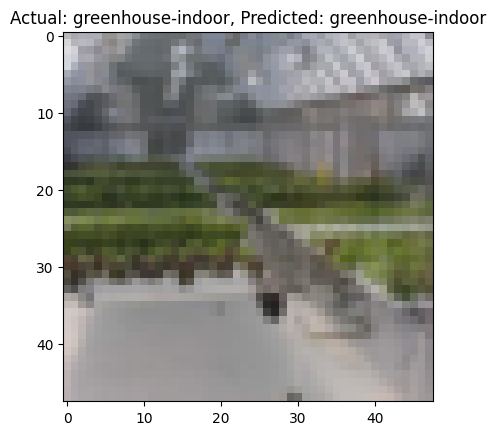

In [21]:

###########################
## Test on train data
cnn_classifier.eval()
# Define class names
class_names = ["amusement_park", "bridge", "greenhouse-indoor", "mountain"]  
# Get a random index from the test set
random_index = random.randint(0, len(train_dataset) - 1)
# Get the image and label at the random index
image, label = train_dataset[random_index]
image = image.to(device)
label = label.to(device)

output = cnn_classifier(image.unsqueeze(0))  # Unsqueeze to add batch dimension

# Apply threshold for multiclass classification
_, predicted_label = torch.max(output, 1)

# Convert labels to class names
actual_class = class_names[int(label)]
predicted_class = class_names[int(predicted_label)]

# Check if the prediction is correct
is_correct = predicted_label == int(label)

# Print results
print(f"Actual Class: {actual_class}, Predicted Class: {predicted_class}, Correct: {is_correct}")

# Display the image
image = image.cpu().permute(1, 2, 0).numpy()  # Convert to numpy and rearrange dimensions
plt.imshow(image)
plt.title(f"Actual: {actual_class}, Predicted: {predicted_class}")
plt.show()




## Test based off random image from test dataset


In [22]:


cnn_classifier.eval()

# Define class names
class_names = ["amusement_park", "bridge" ,"greenhouse_indoor", "mountain"] 

# Get a random index from the test set
random_index = random.randint(0, len(test_dataset) - 1)

# Get the image and label at the random index
image, label = test_dataset[random_index]
image = image.to(device)
label = label.to(device)



Actual Class: greenhouse_indoor, Predicted Class: greenhouse_indoor, Correct: tensor([True])


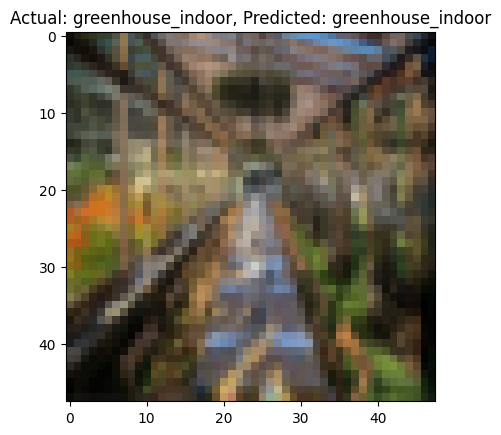

In [23]:

output = cnn_classifier(image.unsqueeze(0))  # Unsqueeze to add batch dimension

# Apply threshold for multiclass classification
_, predicted_label = torch.max(output, 1)

# Convert labels to class names
actual_class = class_names[int(label)]
predicted_class = class_names[int(predicted_label)]

# Check if the prediction is correct
is_correct = predicted_label == int(label)

# Print results
print(f"Actual Class: {actual_class}, Predicted Class: {predicted_class}, Correct: {is_correct}")

# Display the image
image = image.cpu().permute(1, 2, 0).numpy()  # Convert to numpy and rearrange dimensions
plt.imshow(image)
plt.title(f"Actual: {actual_class}, Predicted: {predicted_class}")
plt.show()

